In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

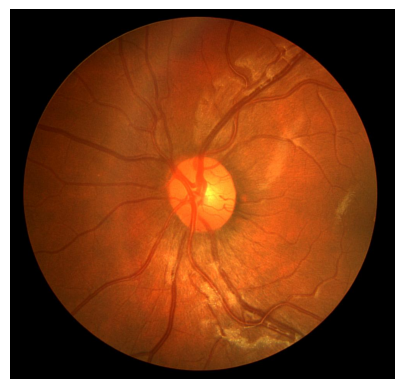

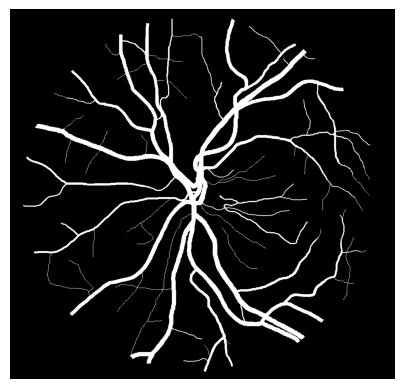

In [2]:
import matplotlib.image as mpimg

image_path = "./chasedb/Image_02L.jpg"
img = mpimg.imread(image_path)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

image_path = "./chasedb/Image_02L_1stHO.png"
img = mpimg.imread(image_path)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [3]:
import matplotlib.image as mpimg

def visualize_img_from_path(path):
  image_path = path
  img = mpimg.imread(image_path)

  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


def visualize_img(image, mask):
    # Convert image and mask tensors to numpy arrays
    image_np = image.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    mask_np = mask.numpy().squeeze()  # Remove the channel dimension if it's one

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Display the image
    axes[0].imshow(image_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms

        self.image_paths = []
        self.mask_paths = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                image_filename = filename
                mask_filename = filename.replace(".jpg", "_1stHO.png")
            elif filename.endswith(".tif"):
                image_filename = filename
                mask_filename = filename.replace("_training.tif", "_manual1.gif")
            else:
                continue

            self.image_paths.append(os.path.join(image_dir, image_filename))
            self.mask_paths.append(os.path.join(mask_dir, mask_filename))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Apply transformations if any
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)


        return (image, mask)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

image_dir_dataset1 = './chasedb'
mask_dir_dataset1 = './chasedb'
dataset1 = SegmentationDataset(image_dir_dataset1, mask_dir_dataset1, transforms=transform)

image_dir_dataset2 = './drive/DRIVE/training/images'
mask_dir_dataset2 = './drive/DRIVE/training/1st_manual'
dataset2 = SegmentationDataset(image_dir_dataset2, mask_dir_dataset2, transforms=transform)



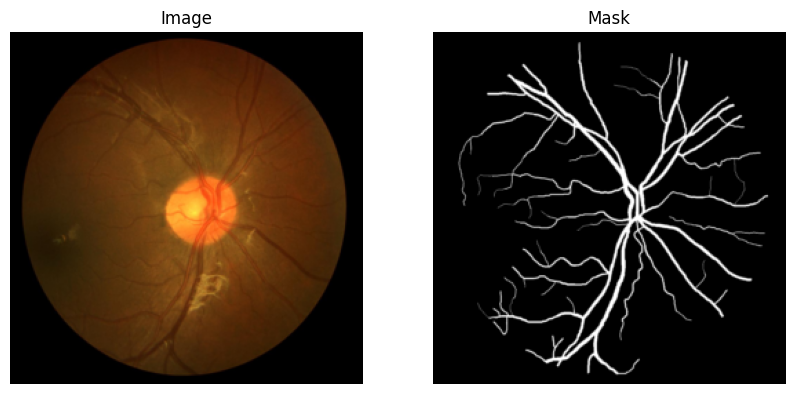

In [5]:
image, mask = dataset1[0] # Get the first image and mask from dataset1
visualize_img(image,mask)

In [6]:
batch_size = 32
dataloader_dataset1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
dataloader_dataset2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [7]:
for images,mask in dataloader_dataset1:
  print(images[0].shape)
  print(mask[0].shape)
  break

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.enc_conv1 = self.conv_block(in_channels, 64)
        self.enc_conv2 = self.conv_block(64, 128)
        self.enc_conv3 = self.conv_block(128, 256)
        self.enc_conv4 = self.conv_block(256, 512)

        # Decoder
        self.dec_conv4 = self.conv_block(512, 256)
        self.dec_conv3 = self.conv_block(256, 128)
        self.dec_conv2 = self.conv_block(128, 64)

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec_conv1 = nn.Conv2d(128, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        # Decoder
        dec4 = self.dec_conv4(torch.cat([enc4, self.upconv4(enc3)], 1))
        dec3 = self.dec_conv3(torch.cat([dec4, self.upconv3(enc2)], 1))
        dec2 = self.dec_conv2(torch.cat([dec3, self.upconv2(enc1)], 1))

        return self.dec_conv1(dec2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


In [9]:
num_classes_dataset1 = 1
num_classes_dataset2 = 1

unet_dataset1 = UNet(in_channels=3, out_channels=num_classes_dataset1)
unet_dataset2 = UNet(in_channels=3, out_channels=num_classes_dataset2)


In [ ]:
!pip install learn2learn

In [10]:
import torch
import torch.optim as optim
import learn2learn as l2l

# Assuming unet_dataset1 and unet_dataset2 are your U-Net models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_dataset1.to(device)
unet_dataset2.to(device)
# Convert your datasets to MetaDatasets
dataset1_meta = l2l.data.MetaDataset(dataset1)
dataset2_meta = l2l.data.MetaDataset(dataset2)

# Define a TaskGenerator for each dataset
task_generator1 = l2l.data.TaskGenerator(dataset1_meta, ways=3, shots=5, tasks=10)
task_generator2 = l2l.data.TaskGenerator(dataset2_meta, ways=3, shots=5, tasks=10)

# Initialize MAML model
maml_model1 = l2l.algorithms.MAML(unet_dataset1, lr=1e-3, first_order=False)
maml_model2 = l2l.algorithms.MAML(unet_dataset2, lr=1e-3, first_order=False)

# Optimizer for MAML model parameters
opt1 = optim.Adam(maml_model1.parameters(), lr=4e-3)
opt2 = optim.Adam(maml_model2.parameters(), lr=4e-3)
num_iterations = 100
adaptation_steps=5

import torch.nn.functional as F

def compute_loss(model, images, masks):
    # Forward pass
    outputs = model(images)
    # Compute binary cross-entropy loss
    loss = F.binary_cross_entropy_with_logits(outputs, masks)
    return loss

# Training loop
for iteration in range(num_iterations):
    for task_data in task_generator1:
        # Get task-specific data
        images, masks = task_data
        images = images.to(device)
        masks = masks.to(device)

        # Perform MAML update
        learner1 = maml_model1.clone() # Creates a clone of model
        for step in range(adaptation_steps):
            error = compute_loss(learner1, images, masks)
            learner1.adapt(error)

        # Compute evaluation loss
        evaluation_error = compute_loss(learner1, images, masks)

        # Meta-update the model parameters
        opt1.zero_grad()
        evaluation_error.backward()
        opt1.step()

    # Repeat the process for the second dataset
    for task_data in task_generator2:
        images, masks = task_data
        images = images.to(device)
        masks = masks.to(device)

        learner2 = maml_model2.clone()
        for step in range(adaptation_steps):
            error = compute_loss(learner2, images, masks)
            learner2.adapt(error)

        evaluation_error = compute_loss(learner2, images, masks)

        opt2.zero_grad()
        evaluation_error.backward()
        opt2.step()

# Save the trained models
torch.save(maml_model1.state_dict(), 'maml_unet_model1.pth')
torch.save(maml_model2.state_dict(), 'maml_unet_model2.pth')


RuntimeError: a Tensor with 65536 elements cannot be converted to Scalar